# Prior Distributions 之选择 {#sec-choose-prior-dist}

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import binom 

一枚硬币，随机抛掷 250 次，观测的结果是 140 次正面朝上，110 次背面朝上。将这枚硬币随机抛掷一次，是正面朝上的概率最有可能是多少？

![古越涛抛硬币](public/img/coins.jpeg){fig-alt="古越涛抛硬币"}

**上图来自[搜狐](https://www.sohu.com/a/225881799_100071627)** 

我们可以用 @sec-dist 那部分的例子来思考。

可以把这个问题转化为：

我们目前有 $n+1$ 枚硬币，其各有如下特征：

- 随机抛硬币 0，正面朝上的概率是 0/n
- 随机抛硬币 1，正面朝上的概率是 1/n
- 随机抛硬币 2，正面朝上的概率是 2/n\
...
- 随机抛硬币 n，正面朝上的概率是 n/n

我们从这些硬币中随机挑了一枚，随机抛掷 250 次，观测的结果是 140 次正面朝上，110 次背面朝上。这枚硬币最有可能是哪枚硬币？

我们先用 uniform prior，也就是说，每一枚硬币是该硬币的概率相同。

In [2]:
def normalize_array(arr):
    return np.array([i/sum(arr) for i in arr])

# 稍微修改一下之前的 update_bowls_pmf
def update_coins_pmf(n, h, t):
    """
    n: 总共几枚硬币
    h: 正面朝上
    t: 背面朝上
    """
    prior = np.array([1]*n)
    prior = normalize_array(prior)
    likelihood_head = np.array([i/(n-1) for i in range(n)])
    likelihood_tail = np.array([1- i for i in likelihood_head])
    likelihood = {
        "head": likelihood_head,
        "tail": likelihood_tail
    }
    dataset = ["head"]*h + ["tail"]*t
    posterior = prior.copy()
    for data in dataset:
        posterior *= likelihood[data]
    return normalize_array(posterior)

In [3]:
posterior = update_coins_pmf(1001, 140, 110)

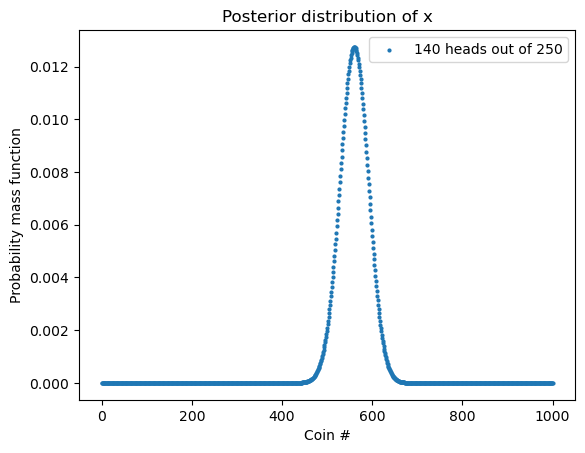

In [4]:
#| code-fold: true
df = pd.DataFrame(posterior, columns=['probs'])
df = df.reset_index(names = "Coin #")
df.plot.scatter(x = "Coin #", y="probs", 
                s = 4,
                label = "140 heads out of 250")
plt.ylabel("Probability mass function")
plt.legend()
plt.title("Posterior distribution of x")
plt.show()

## 不同的 Prior Distributions

上面我们用到的是 uniform prior：

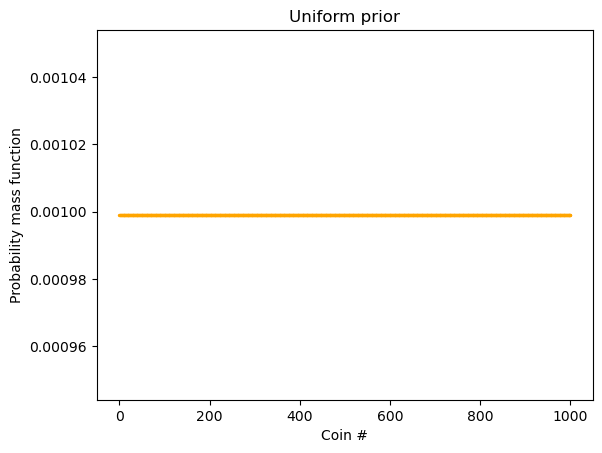

In [5]:
#| code-fold: true
n = 1001
prior = np.array([1]*n)
uniform = normalize_array(prior)
x_axis = range(n)
plt.scatter(x = x_axis, y = uniform, 
            label="prior", color="orange", s = 2)
plt.xlabel("Coin #")
plt.ylabel("Probability mass function")
plt.title("Uniform prior")
plt.show()

但是该 prior 并不一定是 uniform 的，也可能是这样子：

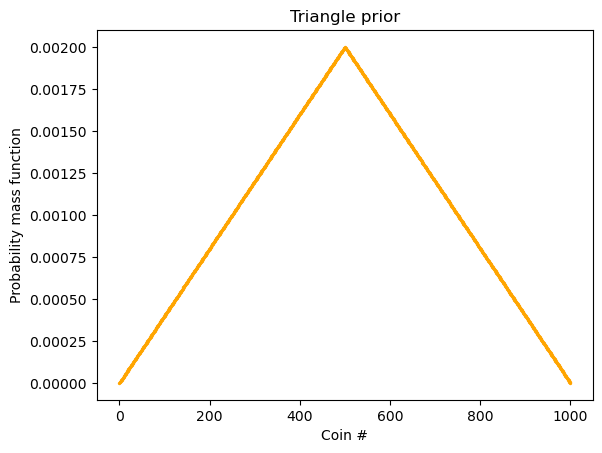

In [6]:
#| code-fold: true
ramp_up = np.arange(500)
ramp_down = np.arange(500, -1, -1)
prior = np.append(ramp_up, ramp_down)
triangle = normalize_array(prior)
plt.scatter(x = x_axis, y = triangle, 
            label="prior", color="orange", s = 2)
plt.xlabel("Coin #")
plt.ylabel("Probability mass function")
plt.title("Triangle prior")
plt.show()

如果我们用如此的 prior，结果是什么呢：

In [7]:
# 稍微修改一下之前的 update_coins_pmf 以便可以修改 prior 
def update_coins_pmf(n, h, t, prior):
    """
    n: 总共几枚硬币
    h: 正面朝上
    t: 背面朝上
    prior: a normalized array
    """
    likelihood_head = np.array([i/(n-1) for i in range(n)])
    likelihood_tail = np.array([1- i for i in likelihood_head])
    likelihood = {
        "head": likelihood_head,
        "tail": likelihood_tail
    }
    dataset = ["head"]*h + ["tail"]*t
    posterior = prior.copy()
    for data in dataset:
        posterior *= likelihood[data]
    return normalize_array(posterior)

In [8]:
n = 1001
h = 140
t = 110
ramp_up = np.arange(500)
ramp_down = np.arange(500, -1, -1)
prior = np.append(ramp_up, ramp_down)
prior = normalize_array(prior)

posterior = update_coins_pmf(n, h, t, prior)

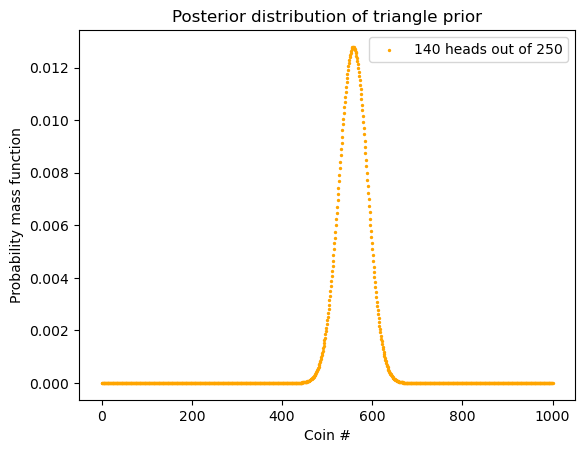

In [9]:
#| code-fold: true
plt.scatter(x = x_axis, y = posterior, 
            label="140 heads out of 250", color="orange", s = 2)
plt.xlabel("Coin #")
plt.ylabel("Probability mass function")
plt.title("Posterior distribution of triangle prior")
plt.legend()
plt.show()

In [10]:
max_index = np.argmax(posterior)
print("最高点出现在 Coin #", max_index)

最高点出现在 Coin # 558


我们看到和用 uniform prior 结果差不多。这说明什么？这说明数据够多的话，prior 对 posterior 的影响没那么大。

但我们来个更极端的：随机 prior。

In [11]:
random_prior_values = np.random.rand(n)
random_prior = normalize_array(random_prior_values)

posterior = update_coins_pmf(n, h, t, prior=random_prior)

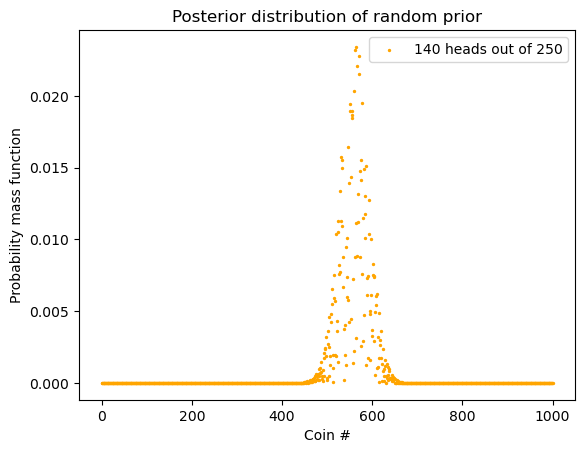

In [12]:
#| code-fold: true
plt.scatter(x = x_axis, y = posterior, 
            label="140 heads out of 250", color="orange", s = 2)
plt.xlabel("Coin #")
plt.ylabel("Probability mass function")
plt.title("Posterior distribution of random prior")
plt.legend()
plt.show()

In [13]:
max_index = np.argmax(posterior)
print("最高点出现在 Coin #", max_index)

最高点出现在 Coin # 565


我们看到，其实结果依然没有太大的影响。这进一步说明「这说明数据够多的话，prior 对 posterior 的影响没那么大」。



## Batch updating

上面我们是一个数据点一个数据点地在更新 posterior：

```py
for data in dataset:
    posterior *= likelihood[data]
```

我们之前证明过了，顺序不重要，那我们就把「随机抛掷 250 次，观测的结果是 140 次正面朝上，110 次背面朝上」当成一个单独的事件就好了。这个事件也就是 Data。

我们来分析：

- hypothesis: 哪枚硬币
- data: 随机抛掷 250 次，观测的结果是 140 次正面朝上，110 次背面朝上
- prior: $p(h)$
- likelihood: $p(d|h)$
- posterior: $p(h|d)$

我们现在要用 prior 和 likelihood 求得 posterior。Prior 我们有了，不管是最开始的 uniform prior 还是 triangle prior，其本质就是一个数组 (array) 而已。那我们如何得到 Likelihood 这一数组？需要用到 [binomial distribution](https://hongtaoh.com/cn/2024/03/23/discrete-distributions/#binomial-distribution)：

$$P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}$$

我们用 [`scipy.stats.binom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)。

```
scipy.stats.binom.pmf(k, n, p)
```

其中 k 是正面朝上的次数，n 是总攻抛掷的次数， p 是正面朝上的概率。需要注意的是，p 可以是一个数，也可以是一组数。当 p 是一个数时，其结果是一个数。当 p 是一组数时，结果是一组数。

其实，这里的 $p$ 就是 prior 这一数组

In [14]:
def update_binom(n, heads, tosses, prior):
    """
    heads: number of heads 
    tosses: total tosses 
    prior: prior distribution; should be a empiricaldist.pmf object (a Series)
    """
    # 0/n, 1/n, 2/n ...
    likelihood_head = np.array([i/(n-1) for i in range(n)])
    coin_head_probabilities = likelihood_head
    likelihood = binom.pmf(k = heads, n = tosses, p = coin_head_probabilities)
    posterior = prior.copy()
    posterior *= likelihood 
    return normalize_array(posterior)

In [15]:
# n: number of coins
n = 1001
tosses = 250
# number of heads out of 250 tosses
heads = 140
prior = np.array([1]*n)
uniform = normalize_array(prior)
posterior = update_binom(n, heads, tosses, uniform)

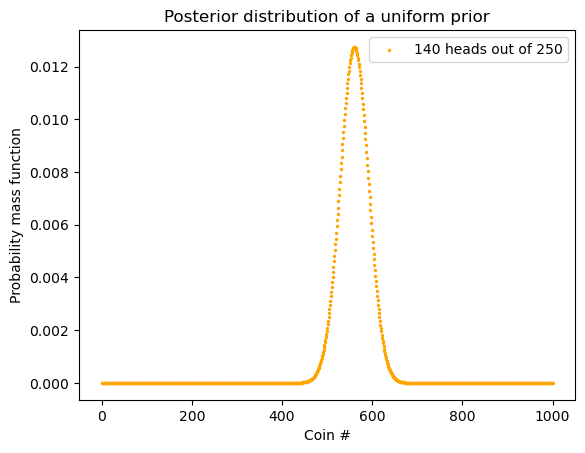

In [16]:
#| code-fold: true
plt.scatter(x = x_axis, y = posterior, 
            label="140 heads out of 250", color="orange", s = 2)
plt.xlabel("Coin #")
plt.ylabel("Probability mass function")
plt.title("Posterior distribution of a uniform prior")
plt.legend()
plt.show()